# ShuffleNet

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Model

from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU, 
                                    MaxPooling2D, Add, GlobalAveragePooling2D, 
                                    Dense, DepthwiseConv2D, Lambda, Reshape, 
                                    Concatenate)

2024-11-26 07:29:00.747016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 07:29:00.949233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732624141.028735   50150 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732624141.047799   50150 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 07:29:01.233607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Preparation for trainning - Train Split

In [3]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image After Data Augmentation, Image Size 224x224/')

In [4]:
batch_size_n = 8

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 6106 files for training.


I0000 00:00:1732624146.932624   50150 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
classes_ = train_ds.class_names
len(classes_)

8

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 1526 files for validation.


In [8]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

train_ds, val_ds

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Preparation for trainning - Test Split

In [9]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image Before Data Augmentation, Image Size 224x224/')

In [10]:
train_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 170 files for training.


In [11]:
val_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 42 files for validation.


In [12]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds_test = train_ds_test.map(normalize)
val_ds_test = val_ds_test.map(normalize)

train_ds_test, val_ds_test

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Training

In [13]:
def channel_shuffle(x, groups):
    height, width, in_channels = x.shape[1:]
    channels_per_group = in_channels // groups

    # Reshape into (batch, height, width, groups, channels_per_group)
    x = tf.reshape(x, [-1, height, width, groups, channels_per_group])
    x = tf.transpose(x, [0, 1, 2, 4, 3])  # Swap channels_per_group and groups
    x = tf.reshape(x, [-1, height, width, in_channels])  # Reshape back
    return x

def shuffle_unit(inputs, out_channels, stride, groups):
    in_channels = inputs.shape[-1]
    half_out_channels = out_channels // 2

    if stride == 2:
        # Split channels into two groups: one for the shortcut and one for the main path
        shortcut = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same", use_bias=False)(inputs)
        shortcut = BatchNormalization()(shortcut)
        shortcut = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        shortcut = ReLU()(shortcut)

        # Main path
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)

        # Concatenate shortcut and main path
        x = Concatenate()([shortcut, x])
    else:
        # Main path with no downsampling
        shortcut = inputs
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size=3, strides=stride, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(half_out_channels, kernel_size=1, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)
        
        # Concatenate shortcut and main path
        x = Concatenate()([shortcut, x])
    
    # Apply channel shuffle
    x = Lambda(channel_shuffle, arguments={'groups': groups})(x)
    
    return x

def build_shufflenet(input_shape=(224, 224, 3), num_classes=1000, groups=3):
    inputs = Input(shape=input_shape)
    x = Conv2D(24, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Stacking ShuffleNet units
    for out_channels, num_units, stride in [(240, 4, 2), (480, 8, 2), (960, 4, 2)]:
        for i in range(num_units):
            x = shuffle_unit(x, out_channels, stride if i == 0 else 1, groups)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model


model = build_shufflenet(input_shape=(224, 224, 3), num_classes=8, groups=3)


In [14]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              auto_scale_loss='True',
              metrics=['accuracy'])

In [15]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size = batch_size_n,
                    epochs=epochs)

Epoch 1/50


I0000 00:00:1732624160.554898   50244 service.cc:148] XLA service 0x7f69680034c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732624160.556675   50244 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-26 07:29:21.531408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732624163.213237   50244 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-26 07:29:30.754934: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng34{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv (f32[8,2160,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,2160,15,15]{3,2,1,0}, f32[2160,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, feature_group_count=2160, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_

764/764 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.3168 - loss: 1.8442 - val_accuracy: 0.1769 - val_loss: 2.7423
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.4137 - loss: 1.4804 - val_accuracy: 0.4286 - val_loss: 1.8463
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5052 - loss: 1.2802 - val_accuracy: 0.1874 - val_loss: 6.3150
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.5738 - loss: 1.0818 - val_accuracy: 0.4089 - val_loss: 1.9042
Epoch 5/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6873 - loss: 0.8284 - val_accuracy: 0.6612 - val_loss: 1.1264
Epoch 6/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8023 - loss: 0.5583 - val_accuracy: 0.8316 - val_loss: 0.4445
Epoch 7/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8624 - loss: 0.4100 - val_accuracy: 0.8440 - val_loss: 0.4587
Epoch 8/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.9101 - loss: 0.2543 - val_accurac

# Evaluating

In [16]:
history.history

{'accuracy': [0.35031116008758545,
  0.4359646141529083,
  0.5262037515640259,
  0.6057975888252258,
  0.7207664847373962,
  0.8170651793479919,
  0.8773337602615356,
  0.9145103096961975,
  0.9371110200881958,
  0.9358008503913879,
  0.9588928818702698,
  0.9647887349128723,
  0.961840808391571,
  0.972649872303009,
  0.9742875695228577,
  0.9741238355636597,
  0.9785456657409668,
  0.9777268171310425,
  0.9849328398704529,
  0.9824762344360352,
  0.9860792756080627,
  0.9787094593048096,
  0.9934490919113159,
  0.9818211793899536,
  0.9872256517410278,
  0.9846053123474121,
  0.9918113350868225,
  0.9873894453048706,
  0.9932852983474731,
  0.9975433945655823,
  0.9780543446540833,
  0.9906648993492126,
  0.9972158670425415,
  0.9877169728279114,
  0.9949230551719666,
  0.9955781102180481,
  0.98591548204422,
  0.9965607523918152,
  0.9901735782623291,
  0.996888279914856,
  0.9895185232162476,
  0.9986898303031921,
  0.9998362064361572,
  1.0,
  0.9769079685211182,
  0.9995086789131

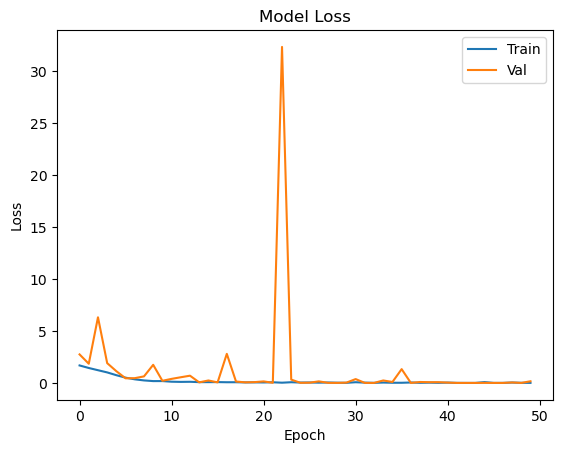

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

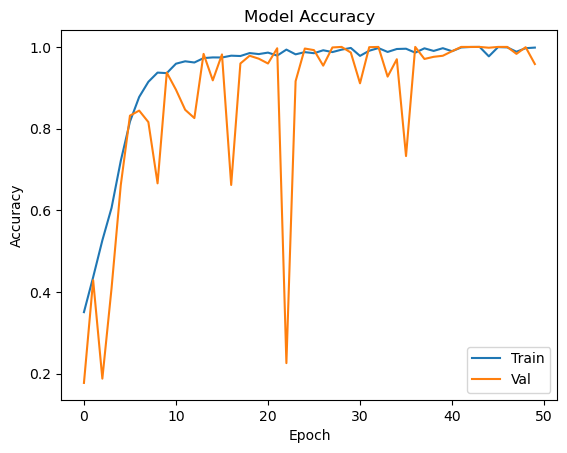

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [19]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

191/191 - 2s - 12ms/step - accuracy: 0.9581 - loss: 0.1591


In [20]:
print(test_acc)

0.9580602645874023


In [21]:
predictions = model.predict(train_ds_test)
val_pred = np.argmax(predictions, axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step


In [22]:
y_true = []
y_pred = []
for images, labels in val_ds_test:
  # Make predictions on the batch
  batch_pred = model.predict(images)
  y_pred.extend(list(batch_pred.argmax(axis=1)))  # Predicted labels
  y_true.extend(list(labels.numpy()))  # True labels from the batch

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-11-26 07:56:56.544696: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


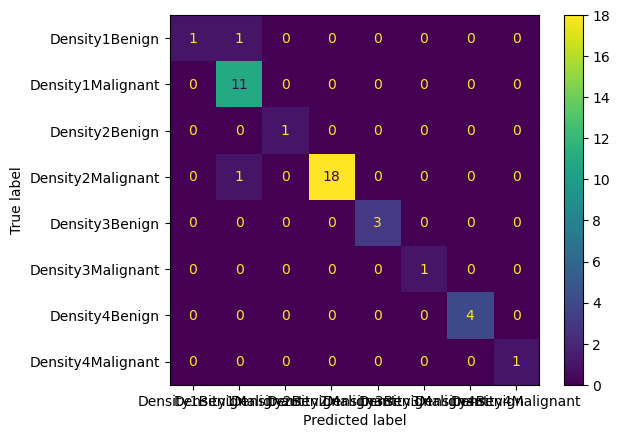

In [23]:
disp = ConfusionMatrixDisplay(cm, display_labels=classes_,)
disp.plot()

In [24]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00         1
           3       1.00      0.95      0.97        19
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1

    accuracy                           0.95        42
   macro avg       0.98      0.93      0.94        42
weighted avg       0.96      0.95      0.95        42



# Save

In [25]:
# model.save('models/breast_cancer_classification-shufflenet.h5')